# Abstract clustering

This notebook contains the process of building an abstract classifier into topics. In order to do this, I develop two alternatives: using a pre-trained model to retrieve embeddings from the data and a topic model (Latent Dirichlet Allocation).

# Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import ticker
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim

from vectorizer import TextVectorizer
from preprocessing import MissingAbstractReplacer, XMLRemover, AbstractCleaner, TextSplitter, StopWordsRemover
from utils import read_xml_data, load_data, get_stopwords

/Users/cavellaneda/Library/Caches/pypoetry/virtualenvs/nsf-abstracts-SqeecLXH-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Pre-trained model

## 1.1 Data pre-processing

In order to have a more maintainable code base, I created a pre-processing pipeline that can grow in the steps it has. For simplicity, I defined only 3 steps:
1. If the abstract is empty, replace it with the Award title.
1. Some texts contain one or more XML breaks, so I replace them with a white space.
1. Vectorize the text using the `all-MiniLM-L12-v2` pre-trained model. This specific model can be replaced for other pre-trained model when instantiating the class; nonetheless, I chose it due to the inference time and for it being a light-weight model.

In [2]:
RAW_FILE_PATH = "nsf_abstract_data.parquet"

In [3]:
if os.path.isfile(RAW_FILE_PATH):
    dataset = pd.read_parquet(RAW_FILE_PATH)
else:
    dataset = read_xml_data("data")
    dataset[["file_name", "AwardTitle", "AbstractNarration"]].to_parquet(RAW_FILE_PATH)

In [5]:
preprocess_pipeline = Pipeline([
    ("missing", MissingAbstractReplacer()),
    ("remover", XMLRemover()),
    ("emb", TextVectorizer())
])

In [5]:
embeddings = preprocess_pipeline.fit_transform(dataset)

Batches: 100%|██████████| 416/416 [07:55<00:00,  1.14s/it]


Given that the previous step can be a computationally expensive process, I persist the data in order to load it easily for further computations.

In [6]:
np.savez_compressed(
    "data/abstracts_embeddings.npz",
    embeddings=embeddings,
    file_names=dataset["file_name"].values.reshape(-1, 1)
)

In [6]:
files, embeddings = load_data("data/abstracts_embeddings.npz")

## 1.2 Cluster Creation

In [42]:
clustering = DBSCAN(eps=0.9, min_samples=10)

In [43]:
labels = clustering.fit_predict(X=embeddings)

In [44]:
pd.Series(labels).value_counts()

 0     8821
-1     4305
 2       66
 7       21
 1       16
 4       12
 3       10
 11      10
 5        9
 8        8
 12       8
 10       6
 9        5
 6        3
Name: count, dtype: int64

One big disadvantage is that there are a lot of documents that fall into the "noisy" category, which is a big indication that the model perhaps is not that useful to understand the underlying information of the documents. Both the clustering model as well as the pre-processing step can be optimized to get better results.

## 1.3 Visualization

In [45]:
X_embedded = TSNE(
    n_components=2, learning_rate='auto', init='random', perplexity=30
).fit_transform(embeddings)

In [46]:
def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(7, 7), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.1)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

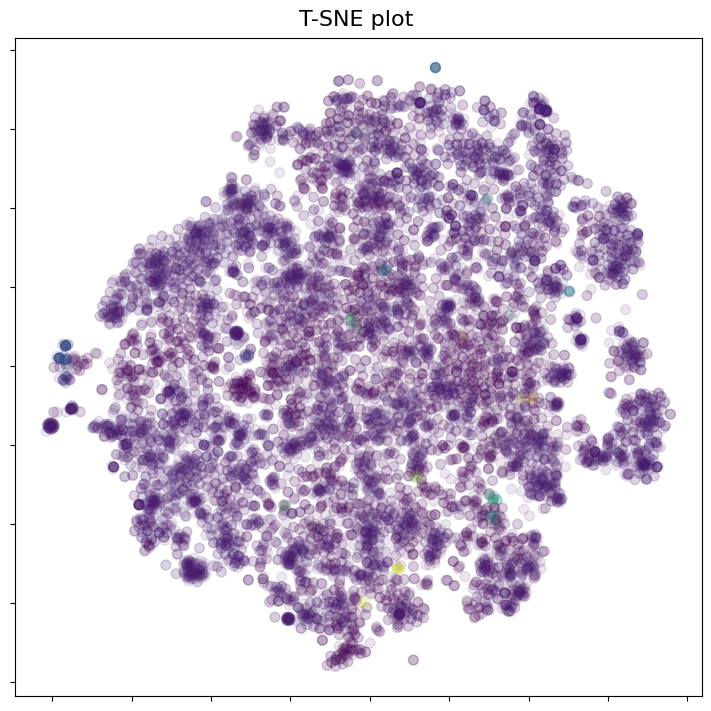

In [48]:
plot_2d(X_embedded, labels, "T-SNE plot")

The previous plot shows the clusters obtained from the previous process. The results show that there is no clear separation between clusters, and the data itself can be very noisy.

Based on the results, there are some disadvantages of this approach.

- First of all, it is possible to find very noisy data on the pre-trained embeddings. This could be overcome by fine-tuning the model with the data.
- Second, further exploration is required related to the hyper-parameters of the model. This process can turn out to be subjective and it might be hard to determine a good set of hyper-parameters.
- Third, one document is assigned to one and only one cluster, which might not be very realistic. One document can talk about several topics and not just one.

As to the advantages:

- It is possible to experiment given the modularity of the pipeline process. It is really simple to test another pre-trained model, or fine-tune the current one and use it instead of the default one.
- It is quite simple to add more steps for the pre-processing pipeline in order to get better results.
- It is possible to try different clustering techniques

# 2. Latent Dirichlet Allocation

In [4]:
stopwords = get_stopwords()

In [7]:
lda_preprocess_pipeline = Pipeline([
    ("missing", MissingAbstractReplacer()),
    ("remover", XMLRemover()),
    ("clean", AbstractCleaner()),
    ("stopwords", StopWordsRemover(stop_words=stopwords)),
    ("splitter", TextSplitter()),
])

In [8]:
texts = lda_preprocess_pipeline.fit_transform(dataset)

In [9]:
print(len(texts))
print(len(texts[0]))

13300
245


In [10]:
%%time
abs_dictionary = Dictionary(texts)
abs_corpus = [abs_dictionary.doc2bow(text) for text in texts]

CPU times: user 4.89 s, sys: 70.6 ms, total: 4.96 s
Wall time: 5.04 s


In [11]:
%%time
lda = LdaModel(abs_corpus, num_topics=150)

CPU times: user 1min 46s, sys: 36 s, total: 2min 22s
Wall time: 28 s


In [12]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(lda, abs_corpus, abs_dictionary)
p

/Users/cavellaneda/Library/Caches/pypoetry/virtualenvs/nsf-abstracts-SqeecLXH-py3.10/lib/python3.10/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
92     0.101467  0.017684       1        1  7.386741
118    0.108286  0.135212       2        1  5.017486
50     0.096666 -0.016318       3        1  3.725007
56     0.102480  0.155654       4        1  2.841123
4      0.090302  0.062556       5        1  2.660167
...         ...       ...     ...      ...       ...
16    -0.261101 -0.036441     146        1  0.054345
103   -0.160956  0.033319     147        1  0.044521
106   -0.382633  0.019351     148        1  0.030693
9     -0.246738 -0.005571     149        1  0.026493
91    -0.346024  0.024153     150        1  0.025309

[150 rows x 5 columns], topic_info=            Term          Freq         Total  Category  logprob  loglift
126      project  42730.000000  42730.000000   Default  30.0000  30.0000
135     research  37743.000000  37743.000000   Default  29.0000  29.0000
256      quantum   4343.000000   4343.000000   Default  28.0000  28.0000
39          data  20401.000000  20401.000000   Default  27.0000  27.0000
751     students  19999.000000  19999.000000   Default  26.0000  26.0000
...          ...           ...           ...       ...      ...      ...
1303   different      0.703155   5116.041372  Topic150  -7.1516  -0.6105
138       review      0.765686  13427.870616  Topic150  -7.0664  -1.4903
170        using      0.798795  21653.009162  Topic150  -7.0241  -1.9258
65    foundation      0.764223  14183.017797  Topic150  -7.0684  -1.5469
24       broader      0.739847  16209.641938  Topic150  -7.1008  -1.7129

[10004 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
2988       1  0.005922       000
2988       2  0.023686       000
2988       3  0.008882       000
2988       4  0.037010       000
2988       5  0.039971       000
...      ...       ...       ...
17066     35  0.858525       zoo
14592      2  0.901114      zoom
5425      22  0.099780  zoonotic
5425      89  0.831499  zoonotic
5425     119  0.033260  zoonotic

[98757 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[93, 119, 51, 57, 5, 148, 53, 123, 138, 46, 6, 75, 80, 99, 115, 116, 18, 147, 144, 77, 47, 19, 22, 110, 60, 21, 35, 34, 81, 14, 45, 128, 41, 49, 105, 28, 25, 117, 48, 30, 44, 103, 31, 132, 143, 55, 83, 118, 136, 145, 26, 135, 66, 7, 100, 139, 76, 86, 38, 101, 126, 72, 87, 32, 113, 149, 52, 73, 67, 20, 102, 134, 43, 150, 90, 69, 15, 59, 114, 78, 54, 129, 23, 37, 50, 79, 97, 27, 61, 16, 62, 56, 2, 71, 84, 146, 4, 40, 91, 24, 68, 106, 124, 65, 88, 11, 9, 8, 94, 127, 39, 108, 112, 89, 121, 63, 95, 33, 29, 12, 120, 70, 1, 64, 82, 109, 98, 141, 125, 36, 42, 74, 111, 58, 96, 3, 130, 85, 133, 13, 142, 140, 131, 122, 137, 17, 104, 107, 10, 92])